## ResNet50 with DAiSEE: Preprocessing, Balancing, Training & Evaluation
#### By: Tan Jun Lin (160989)

Description: 
- This script preprocesses video clips into frames, balances the dataset, trains a ResNet50 model using Focal Loss, and evaluates performance on real-world data.

### 1. Import necessary libraries and paths

In [ ]:
# Import common libraries
import os
import pandas as pd
import numpy as np
import shutil
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Import data preprocessing libraries
import cv2
import multiprocessing as mp
from imblearn.over_sampling import RandomOverSampler

# Import model training and evaluating libraries
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, recall_score


# block warning libraries
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [45]:
# Declare all the necessary paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')
MODEL_DIR = os.path.join(BASE_DIR, 'models')

# Paths that that store in data
LABELS_DIR = os.path.join(DATA_DIR, 'raw/Labels')
DATASET_DIR = os.path.join(DATA_DIR, 'raw/DataSet')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed')
BALANCED_DIR = os.path.join(DATA_DIR, "balance_processed")

LABEL_FILES = {
        'Train': os.path.join(LABELS_DIR, 'TrainLabels.csv'),
        'Validation': os.path.join(LABELS_DIR, 'ValidationLabels.csv'),
        'Test': os.path.join(LABELS_DIR, 'TestLabels.csv')
    }

CASCADE_PATH = os.path.join(BASE_DIR, 'config/haarcascade_frontalface_default.xml')

# Metadata input and output that store in processed dir
INPUT_METADATA = os.path.join(PROCESSED_DATA_DIR, 'metadata.csv')
OUTPUT_METADATA = os.path.join(PROCESSED_DATA_DIR, 'balanced_metadata.csv')

# Paths that store in models
EMOTIONAL_RECOGNITION_MODEL = os.path.join(MODEL_DIR, 'emotional_recognition_model.h5')

### 2. DAiSEE Video Preprocessing & Dataset Preparation

In [ ]:
# Based on DAiSEE predefined labels, classify the classes (customized)
def map_daisee_to_attention(row):
    boredom = row["Boredom"]
    engagement = row["Engagement"]
    confusion = row["Confusion"]
    frustration = row["Frustration"]

    # If high confusion or frustration, classify as 'Lacking_Focus'
    if confusion >= 2 or frustration >= 2:
        return "Lacking_Focus"

    # If high boredom, classify as 'Bored'
    if boredom >= 2:
        return "Bored"

    # If high engagement and low other factors, classify as 'Interested'
    if engagement >= 2 and boredom <= 1 and confusion <= 1 and frustration <= 1:
        return "Interested"

    return "Lacking_Focus"

In [52]:
def detect_and_align_face_fast(image, target_size=(224, 224)):
    face_cascade = cv2.CascadeClassifier(CASCADE_PATH)
    if face_cascade.empty():
        print(f"Error: Failed to load cascade classifier from {CASCADE_PATH}")
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        return None
    x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
    face_img = image[max(0, y - int(h * 0.1)):y + h + int(h * 0.1), max(0, x - int(w * 0.1)):x + w + int(w * 0.1)]
    if face_img.size == 0:
        return None
    return cv2.resize(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB), target_size, interpolation=cv2.INTER_LANCZOS4)

In [53]:
def extract_frames(video_path, output_dir, interval=1.0, max_frames=15):
    os.makedirs(output_dir, exist_ok=True)
    vidcap = cv2.VideoCapture(video_path)
    if not vidcap.isOpened():
        print(f"Error: Cannot open video file: {video_path}")
        return 0
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(1, int(fps * interval))
    frames_to_extract = [i for i in range(0, total_frames, frame_interval)][:max_frames]
    frames_extracted = 0
    for frame_pos in frames_to_extract:
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        success, image = vidcap.read()
        if not success:
            continue
        face_img = detect_and_align_face_fast(image)
        if face_img is None:
            continue
        face_img_resnet = face_img.astype(np.float32) / 255.0
        face_img_save = (face_img_resnet * 255).clip(0, 255).astype(np.uint8)
        frame_filename = os.path.join(output_dir, f"frame_{frames_extracted:03d}.jpg")
        if cv2.imwrite(frame_filename, cv2.cvtColor(face_img_save, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, 95]):
            frames_extracted += 1
    vidcap.release()
    return frames_extracted

In [54]:
def process_video_worker(args):
    row, split = args
    clip_id = row['ClipID']
    label = map_daisee_to_attention(row)
    if label is None:
        return None
    video_path = os.path.join(DATASET_DIR, split, clip_id[:6], clip_id[:-4], clip_id)
    output_folder = os.path.join(PROCESSED_DATA_DIR, split, label, clip_id[:-4])
    if not os.path.exists(video_path):
        return None
    frames_count = extract_frames(video_path, output_folder)
    return {'clip_id': clip_id, 'emotion': label, 'split': split, 'frames': frames_count, 'path': output_folder} if frames_count > 0 else None

In [50]:
def process_dataset(num_workers=None):
    if num_workers is None:
        num_workers = max(1, mp.cpu_count() - 1)
    print(f"Processing with {num_workers} workers...")
    metadata_list = []
    for split, csv_file in LABEL_FILES.items():
        print(f"Processing {split} split...")
        df = pd.read_csv(csv_file)
        args_list = [(row, split) for _, row in df.iterrows()]
        with mp.Pool(processes=num_workers) as pool:
            results = list(tqdm(pool.imap(process_video_worker, args_list), total=len(args_list)))
        valid_results = [result for result in results if result is not None]
        metadata_list.extend(valid_results)
    metadata_df = pd.DataFrame(metadata_list) if metadata_list else pd.DataFrame()
    if not metadata_df.empty:
        metadata_df.to_csv(os.path.join(PROCESSED_DATA_DIR, 'metadata.csv'), index=False)
        print("\nDataset statistics:")
        for split in metadata_df['split'].unique():
            split_df = metadata_df[metadata_df['split'] == split]
            print(f"\n{split.upper()} split:")
            print(f"Total clips: {len(split_df)}")
            for emotion, count in Counter(split_df['emotion']).items():
                print(f"  {emotion}: {count}")
    else:
        print("No videos were successfully processed.")

In [ ]:
# Process the dataset (Extract the features and applied classified into 3 classes based on different labels that provided by DAiSEE datasets)
process_dataset()

Processing with 19 workers...
Processing Train split...


100%|██████████| 5358/5358 [21:52<00:00,  4.08it/s]


Processing Validation split...


100%|██████████| 1429/1429 [04:27<00:00,  5.34it/s]


Processing Test split...


 67%|██████▋   | 1195/1784 [03:49<01:13,  8.05it/s]

### 3. Balancing DAiSEE Training Dataset (Customized Classes)

In [11]:
# Load metadata and read the first 5 rows
def load_metadata():
    """Loads metadata from CSV."""
    if not os.path.exists(INPUT_METADATA):
        raise FileNotFoundError("metadata.csv not found in the processed directory!")
    return pd.read_csv(INPUT_METADATA)

data_df = load_metadata()
print("Metadata Dataframe:\n", data_df.head(2))

Metadata Dataframe:
           clip_id     emotion  split  frames  \
0  1100011002.avi  engagement  Train      10   
1  1100011003.avi  engagement  Train      10   

                                                path  
0  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
1  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  


In [12]:
# Split into train_df, val_df and test_df
train_df = data_df[data_df['split'] == 'Train']
val_df = data_df[data_df['split'] == 'Validation']
test_df = data_df[data_df['split'] == 'Test']

print("\nTrain Dataframe\n", train_df.head(2))
print("\nVal Dataframe\n", val_df.head(2))
print("\nTest Dataframe\n", test_df.head(2))


Train Dataframe
           clip_id     emotion  split  frames  \
0  1100011002.avi  engagement  Train      10   
1  1100011003.avi  engagement  Train      10   

                                                path  
0  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
1  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  

Val Dataframe
              clip_id     emotion       split  frames  \
5340  4000221001.avi  engagement  Validation      10   
5341  4000221002.avi  engagement  Validation      10   

                                                   path  
5340  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
5341  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  

Test Dataframe
              clip_id     emotion split  frames  \
6759  5000441001.avi  engagement  Test      10   
6760  5000441002.avi  engagement  Test      10   

                                                   path  
6759  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
6760  /mnt/d/aispt-ai-model/R

In [13]:
# Visualize Class Distribution for Train Set only
def plot_class_distribution(df, title):
    """Plots class distribution."""
    plt.figure(figsize=(8, 4))
    sns.countplot(x='emotion', data=df, palette='viridis')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()
    
def plot_multiple_distributions(train_df, val_df, test_df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

    sns.countplot(x='emotion', hue='emotion', data=train_df, palette='viridis', legend=False, ax=axes[0])
    axes[0].set_title("Train Before Balancing")
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Count")

    sns.countplot(x='emotion', hue='emotion', data=val_df, palette='plasma', legend=False, ax=axes[1])
    axes[1].set_title("Validation Before Balancing")
    axes[1].set_xlabel("Class")

    sns.countplot(x='emotion', hue='emotion', data=test_df, palette='magma', legend=False, ax=axes[2])
    axes[2].set_title("Test Before Balancing")
    axes[2].set_xlabel("Class")

    plt.tight_layout()
    plt.show()

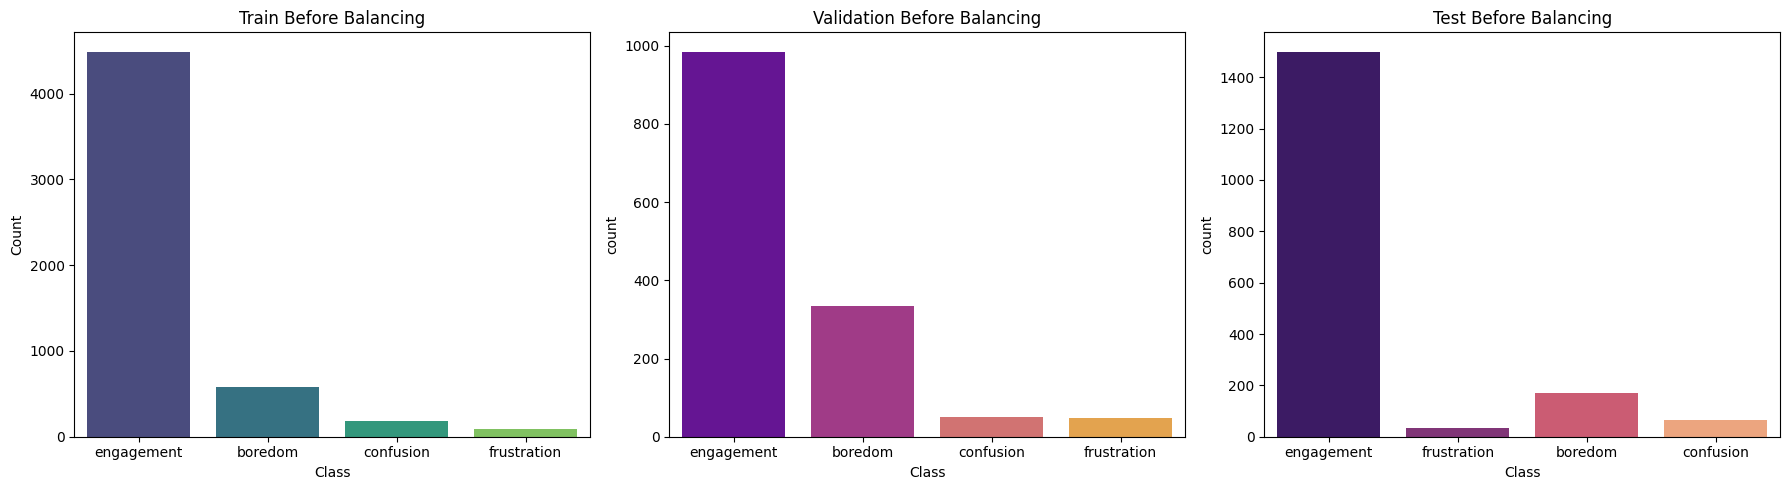

In [104]:
# Show the train, val and test distribution
plot_multiple_distributions(train_df, val_df, test_df)

In [14]:
# Set a target sample based on observation of the graphs
TARGET_SAMPLES_PER_CLASS = 3750 # around 15,000 samples in overall 4 classes (75%)

In [15]:
# Create a new DataFrame specialize for Train Dataset and compute the classes 
class_counts = Counter(train_df['emotion'])
balanced_train_df = pd.DataFrame()

In [16]:
# Balancing Dataset - Downsampling Major Classes
for emotion, count in class_counts.items():
    emotion_df = train_df[train_df['emotion'] == emotion]
    if count > TARGET_SAMPLES_PER_CLASS:
        emotion_df = emotion_df.sample(TARGET_SAMPLES_PER_CLASS, random_state=42)
    balanced_train_df = pd.concat([balanced_train_df, emotion_df])

In [17]:
# Balancing Dataset - Oversampling Minority Classes
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
balanced_train_df, _ = ros.fit_resample(balanced_train_df, balanced_train_df['emotion'])

In [18]:
# Show Class Distribution After Balancing
print("Class distribution after balancing:")
print(balanced_train_df['emotion'].value_counts())

Class distribution after balancing:
emotion
engagement     3750
boredom        3750
confusion      3750
frustration    3750
Name: count, dtype: int64


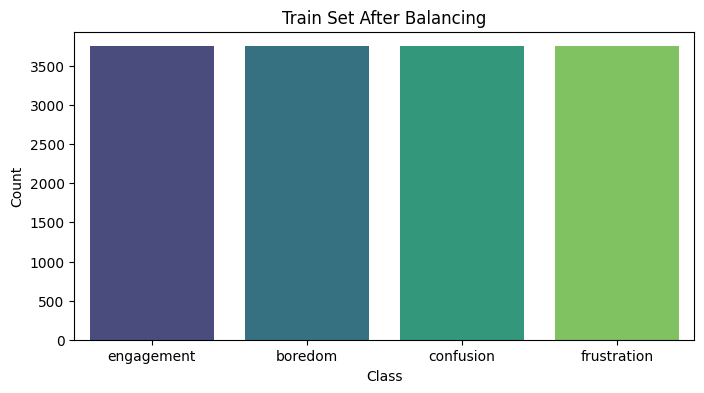

In [21]:
# Plot After Balancing
plot_class_distribution(balanced_train_df, "Train Set After Balancing")

In [23]:
# Combine Balanced Train Data with Validation & Test Data
final_df = pd.concat([balanced_train_df, val_df, test_df])

# Save to CSV (Applied condition)
if not os.path.exists(OUTPUT_METADATA):
    final_df.to_csv(OUTPUT_METADATA, index=False)
    print(f"Metadata saved to {OUTPUT_METADATA}")
else:
    print(f"{OUTPUT_METADATA} already exists. Skipping save.")

/mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/processed/balanced_metadata.csv already exists. Skipping save.


### 4. Organizing Balanced Dataset: Copying Train, Validation, and Test Data to a Balance_Processed Folder

In [24]:
# Read the balanced_metadata csv and show first 5 rows
balanced_df = pd.read_csv(OUTPUT_METADATA)
print(balanced_df.head())

          clip_id     emotion  split  frames  \
0  1100042010.avi  engagement  Train      10   
1  2904280170.mp4  engagement  Train      11   
2  2000501053.avi  engagement  Train      10   
3  2000541071.avi  engagement  Train      10   
4  1100171012.avi  engagement  Train      10   

                                                path  
0  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
1  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
2  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
3  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  
4  /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/dat...  


In [25]:
# Create a balanced df split for easily applied to other row
balanced_df_train = balanced_df[balanced_df["split"] == "Train"]
balanced_df_val = balanced_df[balanced_df["split"] == "Validation"]
balanced_df_test = balanced_df[balanced_df["split"] == "Test"]

In [26]:
# Check for the class split
print("Train Class Distribution:")
print(balanced_df_train["emotion"].value_counts())

print("\nValidation Class Distribution:")
print(balanced_df_val["emotion"].value_counts())

print("\nTest Class Distribution:")
print(balanced_df_test["emotion"].value_counts())

Train Class Distribution:
emotion
engagement     3750
boredom        3750
confusion      3750
frustration    3750
Name: count, dtype: int64

Validation Class Distribution:
emotion
engagement     985
boredom        335
confusion       50
frustration     49
Name: count, dtype: int64

Test Class Distribution:
emotion
engagement     1500
boredom         171
confusion        64
frustration      34
Name: count, dtype: int64


In [33]:
# Initialize balanced dataset directories
train_dir = os.path.join(BALANCED_DIR, "Train")
val_dir = os.path.join(BALANCED_DIR, "Validation")
test_dir = os.path.join(BALANCED_DIR, "Test")

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Print the directories that has been created
print("Balanced Train directory:", train_dir)
print("Balanced Validation directory:", val_dir)
print("Balanced Test directory:", test_dir)

Balanced Train directory: /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train
Balanced Validation directory: /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Validation
Balanced Test directory: /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Test


In [35]:
# Function to move images based on metadata
def move_files(metadata_df, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    
    # Create emotion subdirectories first
    emotions = metadata_df["emotion"].unique()
    for emotion in emotions:
        os.makedirs(os.path.join(target_dir, emotion), exist_ok=True)
    
    # Copy files into respective emotion subdirectories
    for file_path, emotion in tqdm(zip(metadata_df["path"], metadata_df["emotion"]), 
                                   desc=f"Copying files to {target_dir}", unit="file", total=len(metadata_df)):
        file_name = os.path.basename(file_path)
        new_path = os.path.join(target_dir, emotion, file_name)
        
        # Skip if file already exists
        if os.path.exists(new_path):  
            print(f"Warning: {file_path} already exist!")
            continue
        
        if os.path.exists(file_path):
            shutil.copytree(file_path, new_path)
        else:
            print(f"Warning: {file_path} does not exist!")

# Move the files into their respective folders
move_files(balanced_df_train, train_dir)
move_files(balanced_df_val, val_dir)
move_files(balanced_df_test, test_dir)

print("Balanced dataset stored in:", BALANCED_DIR)

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   1%|          | 83/15000 [00:00<00:35, 415.63file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   1%|          | 125/15000 [00:00<00:38, 384.32file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   1%|▏         | 209/15000 [00:00<00:36, 403.04file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   2%|▏         | 289/15000 [00:00<00:38, 382.27file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   2%|▏         | 369/15000 [00:00<00:40, 364.39file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   3%|▎         | 452/15000 [00:01<00:38, 381.73file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   4%|▎         | 533/15000 [00:01<00:36, 391.01file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   4%|▍         | 613/15000 [00:01<00:37, 380.91file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   5%|▍         | 693/15000 [00:01<00:36, 389.17file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   5%|▌         | 775/15000 [00:01<00:35, 396.57file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   6%|▌         | 855/15000 [00:02<00:36, 391.39file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   6%|▌         | 934/15000 [00:02<00:36, 382.09file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   7%|▋         | 1015/15000 [00:02<00:35, 389.95file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   7%|▋         | 1094/15000 [00:02<00:36, 382.23file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   8%|▊         | 1133/15000 [00:02<00:36, 376.61file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   8%|▊         | 1209/15000 [00:03<00:37, 369.39file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   9%|▊         | 1290/15000 [00:03<00:36, 374.20file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:   9%|▉         | 1371/15000 [00:03<00:35, 384.58file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  10%|▉         | 1448/15000 [00:03<00:35, 377.72file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  10%|█         | 1526/15000 [00:03<00:37, 362.71file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  11%|█         | 1601/15000 [00:04<00:36, 365.11file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  11%|█         | 1674/15000 [00:04<00:38, 347.78file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  11%|█▏        | 1709/15000 [00:04<00:43, 305.61file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  12%|█▏        | 1777/15000 [00:04<00:41, 319.24file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  12%|█▏        | 1847/15000 [00:04<00:39, 329.21file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  13%|█▎        | 1920/15000 [00:05<00:39, 334.16file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  13%|█▎        | 1989/15000 [00:05<00:38, 335.51file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  14%|█▎        | 2059/15000 [00:05<00:38, 339.94file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  14%|█▍        | 2132/15000 [00:05<00:36, 351.18file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  15%|█▍        | 2208/15000 [00:06<00:35, 362.58file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  15%|█▌        | 2290/15000 [00:06<00:33, 383.24file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  16%|█▌        | 2374/15000 [00:06<00:35, 357.58file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  16%|█▋        | 2451/15000 [00:06<00:34, 363.53file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  17%|█▋        | 2529/15000 [00:06<00:33, 375.06file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  17%|█▋        | 2606/15000 [00:07<00:32, 377.21file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  18%|█▊        | 2682/15000 [00:07<00:33, 367.60file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  18%|█▊        | 2719/15000 [00:07<00:36, 338.34file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  19%|█▊        | 2798/15000 [00:07<00:33, 361.59file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  19%|█▉        | 2875/15000 [00:07<00:33, 366.91file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  20%|█▉        | 2959/15000 [00:08<00:30, 392.23file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  20%|██        | 3043/15000 [00:08<00:29, 401.55file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  21%|██        | 3127/15000 [00:08<00:29, 403.41file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  21%|██▏       | 3210/15000 [00:08<00:32, 358.71file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  22%|██▏       | 3290/15000 [00:08<00:31, 377.14file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  22%|██▏       | 3374/15000 [00:09<00:29, 393.87file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  23%|██▎       | 3454/15000 [00:09<00:29, 395.49file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  24%|██▎       | 3533/15000 [00:09<00:30, 376.86file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  24%|██▍       | 3616/15000 [00:09<00:28, 393.81file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  24%|██▍       | 3656/15000 [00:09<00:34, 333.57file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  25%|██▍       | 3726/15000 [00:10<00:33, 339.28file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  25%|██▌       | 3796/15000 [00:10<00:32, 340.34file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  26%|██▌       | 3866/15000 [00:10<00:32, 339.43file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  26%|██▋       | 3939/15000 [00:10<00:31, 350.23file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  27%|██▋       | 4009/15000 [00:10<00:34, 315.54file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  27%|██▋       | 4089/15000 [00:11<00:30, 354.31file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  28%|██▊       | 4178/15000 [00:11<00:27, 396.11file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  28%|██▊       | 4260/15000 [00:11<00:26, 402.63file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  29%|██▊       | 4304/15000 [00:11<00:25, 412.75file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  29%|██▉       | 4384/15000 [00:11<00:29, 356.74file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  30%|██▉       | 4458/15000 [00:12<00:30, 348.32file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  30%|███       | 4535/15000 [00:12<00:28, 361.25file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  30%|███       | 4572/15000 [00:12<00:28, 361.47file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  31%|███       | 4645/15000 [00:12<00:31, 330.95file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  31%|███▏      | 4714/15000 [00:12<00:31, 327.83file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  32%|███▏      | 4784/15000 [00:13<00:30, 334.24file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  32%|███▏      | 4850/15000 [00:13<00:34, 294.41file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  33%|███▎      | 4922/15000 [00:13<00:31, 324.04file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  33%|███▎      | 4996/15000 [00:13<00:30, 333.09file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  34%|███▎      | 5030/15000 [00:13<00:30, 326.39file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  34%|███▍      | 5101/15000 [00:14<00:29, 335.38file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  34%|███▍      | 5168/15000 [00:14<00:31, 309.00file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  35%|███▍      | 5236/15000 [00:14<00:31, 309.14file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  35%|███▌      | 5319/15000 [00:14<00:27, 357.03file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  36%|███▌      | 5394/15000 [00:14<00:26, 364.71file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  36%|███▋      | 5466/15000 [00:15<00:29, 319.88file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  37%|███▋      | 5544/15000 [00:15<00:26, 351.73file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  37%|███▋      | 5624/15000 [00:15<00:25, 372.85file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  38%|███▊      | 5662/15000 [00:15<00:25, 359.23file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  38%|███▊      | 5735/15000 [00:15<00:27, 331.70file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  39%|███▊      | 5810/15000 [00:16<00:26, 351.05file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  39%|███▉      | 5887/15000 [00:16<00:24, 364.78file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  40%|███▉      | 5961/15000 [00:16<00:26, 345.51file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  40%|████      | 6041/15000 [00:16<00:24, 370.66file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  41%|████      | 6117/15000 [00:16<00:24, 368.55file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  41%|████      | 6154/15000 [00:17<00:24, 368.09file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  42%|████▏     | 6229/15000 [00:17<00:26, 331.87file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  42%|████▏     | 6306/15000 [00:17<00:24, 356.88file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  43%|████▎     | 6383/15000 [00:17<00:26, 322.77file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  43%|████▎     | 6461/15000 [00:18<00:24, 353.17file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  44%|████▎     | 6540/15000 [00:18<00:22, 371.56file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  44%|████▍     | 6579/15000 [00:18<00:22, 375.15file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  44%|████▍     | 6655/15000 [00:18<00:23, 351.85file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  45%|████▍     | 6731/15000 [00:18<00:22, 363.03file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  45%|████▌     | 6804/15000 [00:18<00:23, 351.77file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  46%|████▌     | 6881/15000 [00:19<00:24, 328.77file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  46%|████▋     | 6960/15000 [00:19<00:22, 358.63file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  47%|████▋     | 7038/15000 [00:19<00:22, 353.38file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  47%|████▋     | 7076/15000 [00:19<00:21, 360.19file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  48%|████▊     | 7149/15000 [00:19<00:23, 337.30file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  48%|████▊     | 7219/15000 [00:20<00:23, 332.15file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  49%|████▊     | 7287/15000 [00:20<00:23, 331.96file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  49%|████▉     | 7354/15000 [00:20<00:25, 300.23file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  50%|████▉     | 7428/15000 [00:20<00:22, 331.39file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  50%|████▉     | 7495/15000 [00:21<00:22, 326.84file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  50%|█████     | 7560/15000 [00:21<00:25, 295.31file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  51%|█████     | 7629/15000 [00:21<00:23, 316.72file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  51%|█████     | 7661/15000 [00:21<00:23, 306.45file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  52%|█████▏    | 7727/15000 [00:21<00:23, 316.06file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  52%|█████▏    | 7797/15000 [00:22<00:24, 294.27file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  52%|█████▏    | 7867/15000 [00:22<00:22, 320.39file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  53%|█████▎    | 7941/15000 [00:22<00:21, 330.66file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  53%|█████▎    | 8019/15000 [00:22<00:20, 335.15file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  54%|█████▍    | 8104/15000 [00:22<00:18, 374.91file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  55%|█████▍    | 8184/15000 [00:23<00:17, 385.56file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  55%|█████▍    | 8223/15000 [00:23<00:19, 353.79file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  55%|█████▌    | 8300/15000 [00:23<00:18, 354.27file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  56%|█████▌    | 8381/15000 [00:23<00:18, 353.41file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  56%|█████▋    | 8466/15000 [00:23<00:16, 389.43file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  57%|█████▋    | 8546/15000 [00:24<00:17, 375.68file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  57%|█████▋    | 8584/15000 [00:24<00:18, 345.21file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  58%|█████▊    | 8668/15000 [00:24<00:16, 378.33file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  58%|█████▊    | 8749/15000 [00:24<00:16, 389.95file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  59%|█████▉    | 8832/15000 [00:24<00:17, 360.79file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  59%|█████▉    | 8906/15000 [00:25<00:17, 340.64file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  60%|█████▉    | 8976/15000 [00:25<00:18, 331.19file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  60%|██████    | 9010/15000 [00:25<00:19, 300.13file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  61%|██████    | 9078/15000 [00:25<00:18, 317.36file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  61%|██████    | 9152/15000 [00:25<00:20, 292.26file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  61%|██████▏   | 9215/15000 [00:26<00:19, 298.15file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  62%|██████▏   | 9250/15000 [00:26<00:18, 311.51file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  62%|██████▏   | 9319/15000 [00:26<00:18, 313.11file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  63%|██████▎   | 9390/15000 [00:26<00:16, 331.50file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  63%|██████▎   | 9468/15000 [00:26<00:15, 358.44file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  64%|██████▎   | 9546/15000 [00:27<00:15, 341.45file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  64%|██████▍   | 9626/15000 [00:27<00:16, 333.87file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  65%|██████▍   | 9701/15000 [00:27<00:16, 329.47file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  65%|██████▌   | 9780/15000 [00:27<00:14, 358.75file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  65%|██████▌   | 9823/15000 [00:27<00:13, 376.65file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  66%|██████▌   | 9897/15000 [00:28<00:15, 319.83file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  66%|██████▋   | 9970/15000 [00:28<00:16, 312.56file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  67%|██████▋   | 10046/15000 [00:28<00:14, 340.48file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  67%|██████▋   | 10083/15000 [00:28<00:14, 346.08file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  68%|██████▊   | 10153/15000 [00:28<00:15, 322.55file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  68%|██████▊   | 10229/15000 [00:29<00:13, 347.11file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  69%|██████▉   | 10315/15000 [00:29<00:13, 340.37file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  69%|██████▉   | 10401/15000 [00:29<00:12, 378.28file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  70%|██████▉   | 10480/15000 [00:29<00:13, 342.67file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  70%|███████   | 10517/15000 [00:29<00:12, 349.06file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  71%|███████   | 10588/15000 [00:30<00:12, 341.74file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  71%|███████   | 10663/15000 [00:30<00:13, 324.81file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  72%|███████▏  | 10732/15000 [00:30<00:13, 327.38file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  72%|███████▏  | 10806/15000 [00:30<00:12, 327.03file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  73%|███████▎  | 10882/15000 [00:30<00:11, 347.03file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  73%|███████▎  | 10917/15000 [00:31<00:11, 343.17file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  73%|███████▎  | 10990/15000 [00:31<00:12, 329.52file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  74%|███████▍  | 11074/15000 [00:31<00:10, 370.52file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  74%|███████▍  | 11155/15000 [00:31<00:10, 369.56file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  75%|███████▍  | 11239/15000 [00:31<00:11, 339.23file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  75%|███████▌  | 11311/15000 [00:32<00:11, 333.12file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  76%|███████▌  | 11348/15000 [00:32<00:10, 342.99file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  76%|███████▌  | 11417/15000 [00:32<00:11, 318.96file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  77%|███████▋  | 11490/15000 [00:32<00:11, 309.14file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  77%|███████▋  | 11558/15000 [00:32<00:10, 318.38file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  78%|███████▊  | 11626/15000 [00:33<00:11, 293.42file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  78%|███████▊  | 11697/15000 [00:33<00:10, 321.60file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  78%|███████▊  | 11730/15000 [00:33<00:10, 319.96file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  79%|███████▊  | 11797/15000 [00:33<00:10, 300.96file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  79%|███████▉  | 11867/15000 [00:33<00:09, 320.85file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  80%|███████▉  | 11938/15000 [00:34<00:09, 330.11file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  80%|████████  | 12007/15000 [00:34<00:09, 319.77file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  81%|████████  | 12091/15000 [00:34<00:07, 367.56file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  81%|████████  | 12167/15000 [00:34<00:08, 344.64file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  82%|████████▏ | 12240/15000 [00:35<00:07, 345.42file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  82%|████████▏ | 12275/15000 [00:35<00:07, 345.09file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  82%|████████▏ | 12352/15000 [00:35<00:07, 350.99file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  83%|████████▎ | 12430/15000 [00:35<00:07, 334.01file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  83%|████████▎ | 12507/15000 [00:35<00:07, 355.92file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  84%|████████▍ | 12579/15000 [00:36<00:07, 318.24file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  84%|████████▍ | 12616/15000 [00:36<00:07, 331.36file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  85%|████████▍ | 12685/15000 [00:36<00:07, 318.79file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  85%|████████▌ | 12755/15000 [00:36<00:07, 308.09file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  86%|████████▌ | 12829/15000 [00:36<00:06, 332.97file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  86%|████████▌ | 12898/15000 [00:37<00:06, 301.92file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  86%|████████▋ | 12971/15000 [00:37<00:06, 330.60file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  87%|████████▋ | 13005/15000 [00:37<00:05, 333.16file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  87%|████████▋ | 13071/15000 [00:37<00:06, 311.44file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  88%|████████▊ | 13133/15000 [00:37<00:06, 287.94file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  88%|████████▊ | 13199/15000 [00:38<00:05, 306.40file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  88%|████████▊ | 13264/15000 [00:38<00:06, 284.72file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  89%|████████▉ | 13332/15000 [00:38<00:05, 307.89file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  89%|████████▉ | 13364/15000 [00:38<00:05, 297.99file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  90%|████████▉ | 13439/15000 [00:38<00:04, 332.54file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  90%|█████████ | 13528/15000 [00:39<00:04, 345.02file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  91%|█████████ | 13603/15000 [00:39<00:04, 346.86file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  91%|█████████ | 13674/15000 [00:39<00:04, 324.36file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  92%|█████████▏| 13743/15000 [00:39<00:03, 333.87file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  92%|█████████▏| 13777/15000 [00:39<00:03, 312.61file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  92%|█████████▏| 13846/15000 [00:40<00:03, 328.73file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  93%|█████████▎| 13918/15000 [00:40<00:03, 315.98file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  93%|█████████▎| 13994/15000 [00:40<00:02, 346.76file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  94%|█████████▍| 14080/15000 [00:40<00:02, 345.73file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  94%|█████████▍| 14156/15000 [00:40<00:02, 351.54file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  95%|█████████▍| 14227/15000 [00:41<00:02, 333.69file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  95%|█████████▌| 14261/15000 [00:41<00:02, 325.78file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  96%|█████████▌| 14330/15000 [00:41<00:02, 309.45file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  96%|█████████▌| 14392/15000 [00:41<00:02, 284.74file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  96%|█████████▋| 14456/15000 [00:41<00:01, 282.81file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  97%|█████████▋| 14524/15000 [00:42<00:01, 309.64file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  97%|█████████▋| 14556/15000 [00:42<00:01, 292.13file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  97%|█████████▋| 14624/15000 [00:42<00:01, 292.32file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  98%|█████████▊| 14697/15000 [00:42<00:00, 323.15file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  98%|█████████▊| 14763/15000 [00:42<00:00, 304.89file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  99%|█████████▉| 14828/15000 [00:43<00:00, 309.37file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train:  99%|█████████▉| 14860/15000 [00:43<00:00, 286.69file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train: 100%|█████████▉| 14932/15000 [00:43<00:00, 317.72file/s]

Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Train: 100%|██████████| 15000/15000 [00:43<00:00, 343.40file/s]


Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Validation: 100%|██████████| 1419/1419 [07:42<00:00,  3.07file/s]
Copying files to /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed/Test: 100%|██████████| 1769/1769 [10:01<00:00,  2.94file/s]

Balanced dataset stored in: /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed


### 5. DAiSEE Dataset Model Train & Evaluation (by using Tensorflow & Keras)

##### 5.1 Configure GPU meomory

In [28]:
# Configure gpu memory
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

# Print activated devices        
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##### 5.2 Data Generator Preparation

In [30]:
# Helper function to check the class distribution
def print_class_distribution(labels):
    unique, counts = np.unique(labels, return_counts=True)
    total = len(labels) 
    print("Class Distribution:") 
    for cls, count in zip(unique, counts): 
        percentage = (count / total) * 100 
        print(f"Class {cls}: {count} samples ({percentage:.2f}%)")

In [31]:
train_datagen = ImageDataGenerator(
    rotation_range=10,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    zoom_range=0.1,  
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  
    shear_range=0.1,  
    fill_mode='nearest',  
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=False
)

Found 17429 images belonging to 1769 classes.
Found 13832 images belonging to 1419 classes.
Found 17429 images belonging to 1769 classes.


In [32]:
# Print class distribution for train generator
print("\nTraining Data Class Distribution:")
train_labels = train_generator.classes
print_class_distribution(train_labels)

# Optionally, print for validation and test generators
print("\nValidation Data Class Distribution:")
val_labels = val_generator.classes
print_class_distribution(val_labels)

print("\nTest Data Class Distribution:")
test_labels = test_generator.classes
print_class_distribution(test_labels)


Training Data Class Distribution:
Class Distribution:
Class 0: 10 samples (0.06%)
Class 1: 10 samples (0.06%)
Class 2: 10 samples (0.06%)
Class 3: 10 samples (0.06%)
Class 4: 10 samples (0.06%)
Class 5: 10 samples (0.06%)
Class 6: 10 samples (0.06%)
Class 7: 10 samples (0.06%)
Class 8: 10 samples (0.06%)
Class 9: 10 samples (0.06%)
Class 10: 10 samples (0.06%)
Class 11: 10 samples (0.06%)
Class 12: 10 samples (0.06%)
Class 13: 10 samples (0.06%)
Class 14: 10 samples (0.06%)
Class 15: 10 samples (0.06%)
Class 16: 10 samples (0.06%)
Class 17: 10 samples (0.06%)
Class 18: 10 samples (0.06%)
Class 19: 10 samples (0.06%)
Class 20: 10 samples (0.06%)
Class 21: 10 samples (0.06%)
Class 22: 10 samples (0.06%)
Class 23: 10 samples (0.06%)
Class 24: 10 samples (0.06%)
Class 25: 10 samples (0.06%)
Class 26: 10 samples (0.06%)
Class 27: 10 samples (0.06%)
Class 28: 10 samples (0.06%)
Class 29: 10 samples (0.06%)
Class 30: 10 samples (0.06%)
Class 31: 10 samples (0.06%)
Class 32: 10 samples (0.06%

#### 5.3 Warmup + Cosine Decay Implementation

In [ ]:
# Initialize the necessary variables
initial_lr = 1e-6  
target_lr = 5e-5   
warmup_epochs = 5  
steps_per_epoch = len(train_generator)
epochs = 30

In [ ]:
total_steps = steps_per_epoch * epochs 

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [warmup_epochs * steps_per_epoch], 
    [initial_lr, target_lr]
)

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
    target_lr, decay_steps=total_steps - warmup_epochs * steps_per_epoch, alpha=1e-6
)

final_lr_schedule = lambda step: tf.where(
    step < warmup_epochs * steps_per_epoch,
    lr_schedule(step),
    cosine_decay(step - warmup_epochs * steps_per_epoch)
)

Copying files: 100%|██████████| 1769/1769 [08:50<00:00,  3.34file/s]

Balanced dataset stored in: /mnt/d/aispt-ai-model/ResNet50_with_DAiSEE/data/balance_processed


#### 5.4 Focal Loss Implementation

In [ ]:

def focal_loss(alpha=0.25, gamma=0.2, class_num=2):
    """
    alpha : Balancing parameter for class imbalance
    gamma : Focusing parameter to reduce loss for well-classified examples 
    """
    def focal_loss_fixed(y_true, y_pred):
        """
        y_true : Ground truth labels (one-hot encoded)
        y_pred : Predicted probabilities
        """
        # Convert sparse labels to one-hot if needed
        if len(K.int_shape(y_true)) == 1:
            y_true = tf.one_hot(y_true, depth=class_num)
        
        # Clip predictions to prevent log(0) errors
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Compute cross-entropy
        cross_entropy = -y_true * K.log(y_pred)
        
        # Compute focal loss modulating factor
        probs = tf.reduce_sum(y_true * y_pred, axis=-1)
        modulating_factor = (1 - probs) ** gamma
        
        # Apply alpha balancing
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        
        # Combine components
        focal_loss = alpha_factor * modulating_factor * cross_entropy
        
        return K.mean(focal_loss)
    
    return focal_loss_fixed

#### 5.5 Build ResNet50 model architecture

In [ ]:
# Leverage ResNet50 weights without including output layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze first 80 layer to perform training
for layer in base_model.layers[:80]:  
    layer.trainable = False  
for layer in base_model.layers[80:]:  
    layer.trainable = True

In [ ]:
# Customize the Dense Layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)  
x = tf.keras.layers.ReLU()(x)
x = Dropout(0.5)(x)

x = Dense(128, kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x) 
x = tf.keras.layers.ReLU()(x)
x = Dropout(0.4)(x)

predictions = Dense(4, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=Adam(learning_rate=final_lr_schedule),
    loss=focal_loss(alpha=0.25, gamma=0.2, class_num=3),  
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

#### 5.6 Train the DAiSEE dataset into ResNet50 model

In [ ]:
# Add callbacks features to ensuring can stop early if the accuracy didnt make improvement for both ModelCheckpoint and EarlyStopping for epochs
checkpoint_path = os.path.join(MODEL_DIR, 'best_model.weights.h5')

callbacks = [
            ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=True, mode='max', verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
        ]

In [ ]:
# Start training
history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_generator,
            validation_steps=len(val_generator),
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )

#### 5.7 Model Evaluation

In [ ]:
# Initialize evaluation necessary variable
y_true, y_pred = [], []
steps = len(test_generator)

In [ ]:
for i, (X, y) in tqdm(enumerate(test_generator), total=steps, desc="Evaluating"):
    preds = model.predict(X, verbose=0)
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if i+1 >= steps:
        break
    
y_true = np.array(y_true[:len(y_pred)])
y_pred = np.array(y_pred[:len(y_true)])

In [ ]:
# Print the classification Report
print("\nClassification Report:")
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

recall_per_class = recall_score(y_true, y_pred, average=None)
for idx, emotion in enumerate(class_names):
    print(f"Recall ({emotion}): {recall_per_class[idx]:.4f}")

loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {accuracy:.4f}")

#### 5.8 Save the Trained model

In [ ]:
if not os.path.exists(os.path.dirname(EMOTIONAL_RECOGNITION_MODEL)):
    os.makedirs(os.path.dirname(EMOTIONAL_RECOGNITION_MODEL))
    
model.save(EMOTIONAL_RECOGNITION_MODEL)
print(f"Model saved to {EMOTIONAL_RECOGNITION_MODEL}")